In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from lightgbm import LGBMClassifier
from skopt import gp_minimize, load
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.callbacks import CheckpointSaver
from skopt.plots import plot_convergence
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
%%time
train = pd.read_csv("data/train.csv")
print(train.shape)

(200000, 202)
CPU times: user 5.82 s, sys: 420 ms, total: 6.24 s
Wall time: 6.24 s


In [3]:
%%time
train = pd.read_csv("data/train.csv")
print(train.shape)

(200000, 202)
CPU times: user 5.79 s, sys: 405 ms, total: 6.19 s
Wall time: 6.2 s


In [36]:
features = [f for f in train.columns if f not in ['target', 'ID_code']]

X = train[features]
y = train['target']

In [33]:
space  = [Integer(1, 1000, name='n_iter'),
          Integer(1, 5, name='max_depth'),
          Real(0.05, 1, name='colsample_bytree'),
          Real(0.5, 1, name='subsample'),
          Real(0.001, 10, 'log-uniform', name='lambda_l1'),
          Real(0.001, 10, 'log-uniform', name='lambda_l2'),
          Real(0.001, 1, name='min_split_gain')]

In [27]:
param_list = []
for elem in space:
    param_list.append(elem.name)

In [6]:
@use_named_args(space)
def objective(**params):
    
    folds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 0)
    features = [f for f in train.columns if f not in ['target', 'ID_code']]
    
    oof_preds = np.zeros(train.shape[0])
    
    scores = []
    
    clf = LGBMClassifier(objective = 'binary',
                         metric = 'auc',
                         random_state = 0,
                         n_thread = 4)
        
    clf.set_params(**params)
    
    for param, value in params.items():
        print(f"{param}: {value}")
    
    for n_fold, (train_index, valid_index) in enumerate(folds.split(train[features], train['target'])):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    
        clf.fit(X_train, y_train, 
              eval_set=[(X_valid, y_valid)], 
              verbose=0, 
              early_stopping_rounds=100)
        
        oof_preds[valid_index] = clf.predict_proba(X_valid, n_iter=clf.best_iteration_)[:, 1]
        
        score = roc_auc_score(y_valid, oof_preds[valid_index])
        scores.append(score)
    
    cv = np.mean(scores)
    print(f"AUC folds: {scores}\n Average AUC: {cv}")
        
    return -cv

In [7]:
checkpoint_saver = CheckpointSaver("./bayesopt_checkpoint.pkl", compress=9) # keyword arguments will be passed to skopt.dump

In [34]:
try:
    res = load('./bayesopt_checkpoint.pkl')

    x_init = res.x_iters
    y_init = res.func_vals
except:
    x_init = None
    y_init = None
finally:
    res_gp = gp_minimize(objective,
                         space,
                         x0 = x_init,
                         y0 = y_init,
                         n_calls=10,
                         n_random_starts = 1,
                         callback = [checkpoint_saver],
                         verbose = True,
                         random_state = 0)

Iteration No: 1 started. Evaluating function at random point.


ValueError: Not all points are within the bounds of the space.

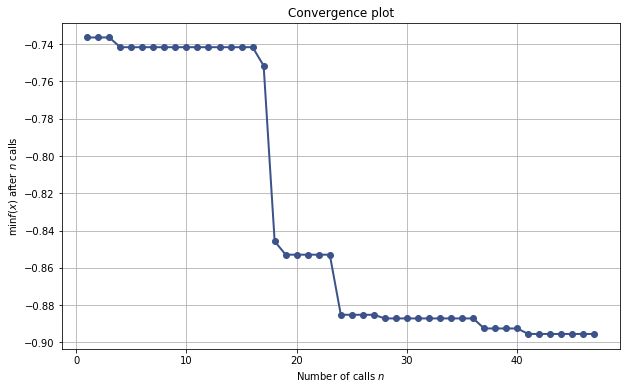

In [30]:
plt.figure(figsize=(10, 6))
plot_convergence(res_gp)
plt.show()

In [31]:
result_df = pd.DataFrame(res_gp.x_iters, columns = param_list)
result_df['CV'] = -res_gp.func_vals
result_df

,n_iter,max_depth,colsample_bytree,subsample,lambda_l1,lambda_l2,min_split_gain,CV
0,6,9,0.865048,0.923626,0.312072,0.034477,0.298237,0.736465
1,2,3,0.503782,0.906084,0.083159,0.037251,0.836243,0.631239
2,6,9,0.859753,0.837843,1.400161,0.150549,0.301149,0.736263
3,6,10,0.748142,0.980718,0.047714,0.006287,0.270242,0.741682
4,1,1,1.000000,0.500000,10.000000,10.000000,0.001000,0.546055
5,6,9,0.865048,0.923626,0.312072,0.034477,0.298237,0.736465
6,2,3,0.503782,0.906084,0.083159,0.037251,0.836243,0.631239
7,5,10,0.171010,0.967337,0.127175,0.001000,0.001000,0.728966
8,10,10,0.050000,1.000000,0.001000,0.001000,0.001000,0.725171
9,1,10,0.050000,0.500000,10.000000,10.000000,1.000000,0.590289


In [32]:
result_df.loc[result_df['CV'].idxmax()]

n_iter              873.000000
max_depth            10.000000
colsample_bytree      0.050000
subsample             0.563154
lambda_l1            10.000000
lambda_l2            10.000000
min_split_gain        1.000000
CV                    0.895449
Name: 40, dtype: float64